<a href="https://colab.research.google.com/github/HerbertMariano/time-series-forecasting/blob/main/mancha_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


In [ ]:
df.isna().sum()

Month       0
Sunspots    0
dtype: int64

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2815,1983-08-01,71.8
2816,1983-09-01,50.3
2817,1983-10-01,55.8
2818,1983-11-01,33.3


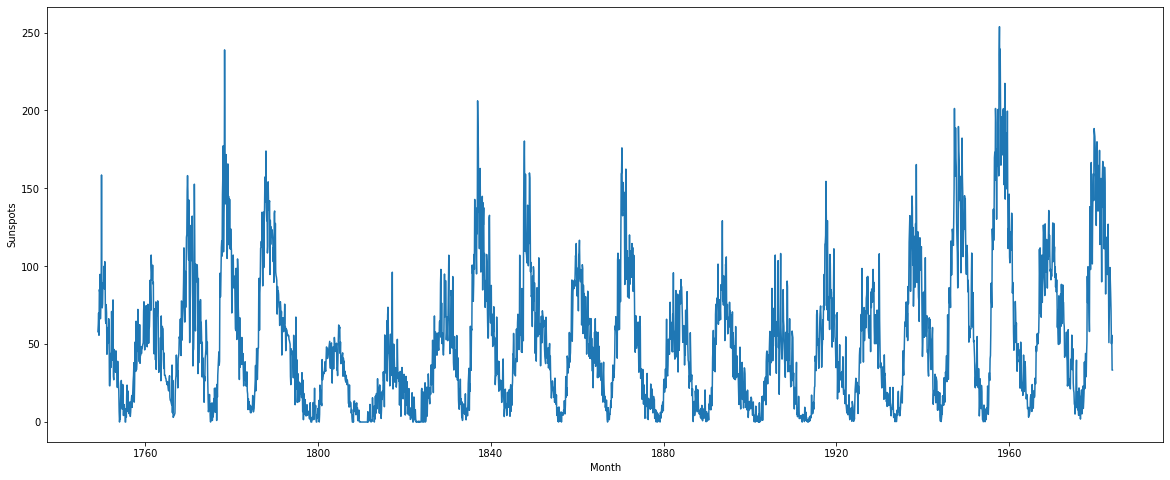

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='Month',y='Sunspots')